In [1]:
import findspark
import os
import sys
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import when, lit, col
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from pyspark.ml.recommendation import ALS, ALSModel


inputsFolder = os.path.join(os.getcwd(), "..", "data")
outputsFolder = os.path.join(os.getcwd(), "..", "result")
image_width = 3000
image_height = 3000
    
alsModelInput_DF_FN = os.path.join(inputsFolder, "ALS Model", 'ALS Model Input.csv')
alsModel_FN = os.path.join(inputsFolder, "ALS Model", 'All Predicted Values.csv')


<generator object _BaseKFold.split at 0x7f3c64c94e40>
round  0
+---------+--------+------+----------+
|Pipelines|Datasets|Status|prediction|
+---------+--------+------+----------+
|        8|      12|     1| 1.2899026|
|       13|      13|     2| 1.9933035|
|        3|      13|     2| 1.3496431|
|        3|       6|     1|0.88843703|
|       12|       3|     2| 1.8407211|
+---------+--------+------+----------+
only showing top 5 rows

round  1
+---------+--------+------+----------+
|Pipelines|Datasets|Status|prediction|
+---------+--------+------+----------+
|       12|      12|     1| 1.1421517|
|       19|      12|     1|0.71342003|
|       28|      13|     2| 2.2838624|
|       14|      13|     2|0.79616106|
|       31|       6|     1|0.37022728|
+---------+--------+------+----------+
only showing top 5 rows

round  2
+---------+--------+------+----------+
|Pipelines|Datasets|Status|prediction|
+---------+--------+------+----------+
|        7|      13|     2| 1.9554918|
|        1|

No handles with labels found to put in legend.


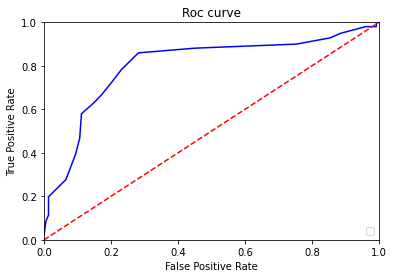

0.7948430619870025


In [2]:

def init_spark():  #initialize spark
    spark = SparkSession \
        .builder \
        .appName("Python Spark SQL Pipeline Recommender") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark

def TPR_FPR(predictions):
    Posetive_class2 = predictions[predictions['Status'] == 2]
    Negative_class1 = predictions[predictions['Status'] == 1]
    TP_df = predictions[(predictions['Status'] == 2) & (predictions['pred_class'] == 2)]
    FP_df = predictions[(predictions['Status'] == 1) & (predictions['pred_class'] == 2)]
    TN_df = predictions[(predictions['Status'] == 1) & (predictions['pred_class'] == 1)]
    FN_df = predictions[(predictions['Status'] == 2) & (predictions['pred_class'] == 1)]

    TPR = TP_df.shape[0]/Posetive_class2.shape[0]
    FPR = FP_df.shape[0]/Negative_class1.shape[0]
    return TPR,FPR


def allThresholds(allFoldsPredictions): #
    thre_TPR_FPR = pd.DataFrame(columns = ['threshold','avg_TPR','avg_FPR'])

    all_avg_TPR = []
    all_avg_FPR = []
    i = 0
    for threshold in np.arange(-0.1,2.4,0.1):
        TPR_list = []
        FPR_list = []
        for predictions in allFoldsPredictions:  #add pred_class column to predictions DF
            #classifiedDF = predictions.withColumn("pred_class", when(col("prediction") >= threshold ,lit(2)).otherwise(lit(1)))
            predictions.loc[predictions['prediction'] <= threshold, 'pred_class'] = 1 
            predictions.loc[predictions['prediction'] > threshold, 'pred_class'] = 2
            
            TPR,FPR = TPR_FPR(predictions)
            TPR_list.append(TPR)
            FPR_list.append(FPR)
        avg_TPR = sum(TPR_list)/len(TPR_list)
        all_avg_TPR.append(avg_TPR)
        avg_FPR = sum(FPR_list)/len(FPR_list)
        all_avg_FPR.append(avg_FPR)
        print("threshold", threshold,"avg_TPR",avg_TPR,"avg_FPR: ",avg_FPR)
        #thre_TPR_FPR = thre_TPR_FPR.append({'threshold':threshold,'avg_TPR': avg_TPR ,'avg_FPR': avg_FPR}, ignore_index = True)
        
    return all_avg_TPR,all_avg_FPR

def alsModel_v4():
    spark = init_spark()
    findspark.init()
    als = ALS(maxIter=5, regParam=0.01, userCol="Pipelines", itemCol="Datasets",ratingCol="Status", coldStartStrategy="drop", rank=10, seed=2020)
    fold_num = 10

    kf = KFold(n_splits=fold_num,shuffle=True)
    df = pd.read_csv(alsModelInput_DF_FN)
    print(kf.split(df))
    
    
    
    allFolds = []
    for k in range (fold_num):
        result = next(kf.split(df), None)
        allFolds.append(result)
        #print(result[1])

    allFoldsPredictions = []
    list_pd_allFoldsPredictions = []

    pd.concat

    for k in range (fold_num):
        result = allFolds[k]
        train = df.iloc[result[0]]
        test =  df.iloc[result[1]]
        spark_train = spark.createDataFrame(train)
        spark_test = spark.createDataFrame(test)
        model = als.fit(spark_train)
        predictions = model.transform(spark_test)
        pd_predictions = predictions.toPandas()
        print("round ",k)

        predictions.show(5, truncate=True)
        pd_predictions[:5]
        list_pd_allFoldsPredictions.append(pd_predictions)

    concat_list_pd_allFoldsPredictions = pd.concat(list_pd_allFoldsPredictions)
    #save all predicted values

    concat_list_pd_allFoldsPredictions.to_csv(alsModel_FN)
    
    minPred = concat_list_pd_allFoldsPredictions['prediction'].min()
    maxPred = concat_list_pd_allFoldsPredictions['prediction'].max()
    print(minPred)
    print(maxPred)


    all_avg_TPR,all_avg_FPR = allThresholds(list_pd_allFoldsPredictions)#,minPred,maxPred)

    # def resultFromFile():
    #     TPR_FPR_results = pd.read_csv('thre_tpr_fpr.csv')

    #     TPR_list = TPR_FPR_results['TPR_avg'].values.tolist() # => [1, 2, 3, 4]
    #     FPR_list = TPR_FPR_results['FPR_avg'].values.tolist()
    #     return(TPR_list,FPR_list)

    # TPR_list,FPR_list = resultFromFile()


    # TPR_list = thre_TPR_FPR['avg_TPR'].values.tolist() # => [1, 2, 3, 4]
    # FPR_list = thre_TPR_FPR['avg_FPR'].values.tolist()
    # print(TPR_list)




    plt.title('Roc curve')
    plt.plot(all_avg_FPR,all_avg_TPR, 'b')#, label='AUC = %0.2f')# % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show(block=False)
    plt.pause(1)
    plt.close()
    #plt.savefig('thre_1-2.png')

    AUC = 0
    for i in range(len(all_avg_TPR)-1):
        AUC = AUC + (((all_avg_TPR[i]+all_avg_TPR[i+1])/2) * (all_avg_FPR[i]-all_avg_FPR[i+1]))
    print(AUC)   

#alsModel_v4()